# Word2Vec
here I implement word2vec with very simple example using tensorflow  
word2vec is vector representation for words with similarity

# Collect Data
we will use only 10 sentences to create word vectors

In [33]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# Remove stop words
In order for efficiency of creating word vector, we will remove commonly used words

In [34]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [35]:
corpus = remove_stop_words(corpus)

In [36]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

here we have word set by which we will have word vector

In [37]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# data generation
we will generate label for each word using skip gram.  

In [38]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [39]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [40]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [41]:
df.shape

(52, 2)

In [42]:
word2int

{'boy': 2,
 'girl': 10,
 'king': 7,
 'man': 5,
 'pretty': 9,
 'prince': 1,
 'princess': 11,
 'queen': 6,
 'strong': 4,
 'wise': 3,
 'woman': 8,
 'young': 0}

# Define Tensorflow Graph

In [43]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Train

In [44]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.2637517
iteration 3000 loss is :  1.8743205
iteration 6000 loss is :  1.8236102
iteration 9000 loss is :  1.7924767
iteration 12000 loss is :  1.7737043
iteration 15000 loss is :  1.7602454
iteration 18000 loss is :  1.7496274


In [45]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 1.2848336e-01  1.5337467e-03]
 [-2.0280635e+00  2.3127823e+00]
 [ 1.7113209e-02  6.8822104e-01]
 [-2.9886007e+00 -2.8444753e+00]
 [-3.6029336e-01  3.9953849e+00]
 [-3.3837869e+00  2.9268253e+00]
 [-2.3786058e+00 -1.4266893e+00]
 [ 7.8221262e-02  5.0086755e-01]
 [-3.9878520e-01 -5.2032435e-01]
 [-3.4548821e+00 -2.6956251e+00]
 [-3.6400979e+00 -2.7140243e+00]
 [-1.7572699e+00 -1.7303076e+00]]


# word vector in table

In [46]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,young,0.128483,0.001534
1,prince,-2.028064,2.312782
2,boy,0.017113,0.688221
3,wise,-2.988601,-2.844475
4,strong,-0.360293,3.995385
5,man,-3.383787,2.926825
6,queen,-2.378606,-1.426689
7,king,0.078221,0.500868
8,woman,-0.398785,-0.520324
9,pretty,-3.454882,-2.695625


# word vector in 2d chart

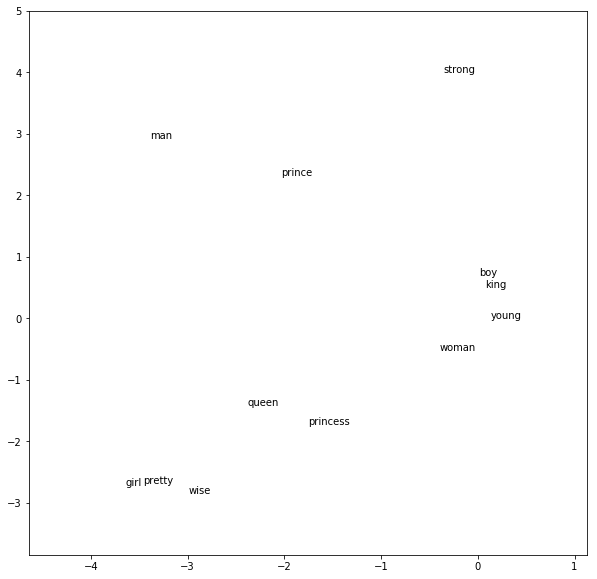

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()